http://tiao.io/posts/notebooks/embedding-matplotlib-animations-in-jupyter-as-interactive-javascript-widgets/

In [1]:
%matplotlib inline

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation, rc
from IPython.display import HTML
import seaborn as sns

In [35]:
sns.set_style('ticks')

In [3]:
# Define the default parameters values
sigma = 10
rho = 28
beta = 8/3

In [4]:
class L63():
    def __init__(self, sigma, rho, beta, init, dt):
        self.sigma, self.rho, self.beta = sigma, rho, beta 
        self.x, self.y, self.z = init
        self.dt = dt
        self.hist = [init]
    
    def step(self):
        self.x += (self.sigma * (self.y - self.x)) * self.dt
        self.y += (self.x * (self.rho - self.z)) * self.dt
        self.z += (self.x * self.y - self.beta * self.z) * self.dt
        self.hist.append([self.x, self.y, self.z])
    
    def integrate(self, n_steps):
        for n in range(n_steps): self.step()

In [45]:
l1 = L63(sigma, rho, beta, init=[1, 10, 20], dt=1e-2)
l1.integrate(3000)

In [46]:
l2 = L63(sigma, rho, beta, init=[1.1, 10, 20], dt=1e-2)
l2.integrate(3000)

In [47]:
y1 = np.array(l1.hist)[::10, 0]
y2 = np.array(l2.hist)[::10, 0]

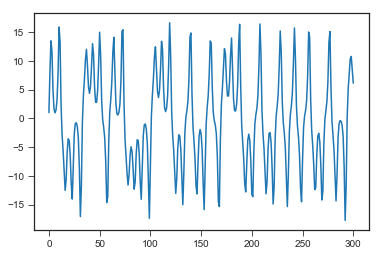

In [48]:
plt.plot(y1);

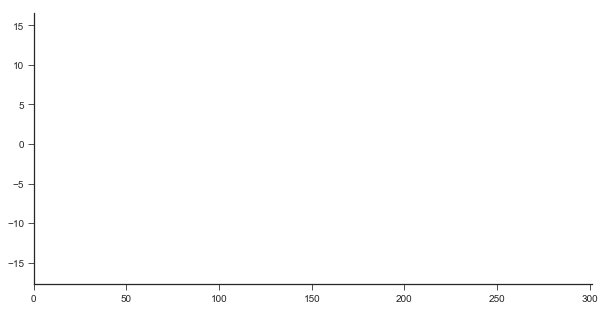

In [49]:
fig, ax = plt.subplots(figsize=(10, 5));
ax.set_ylim(np.min(y1), np.max(y1))
ax.set_xlim(0, len(y1))
line1, = ax.plot([], [], lw=2)
line2, = ax.plot([], [], lw=2)
sns.despine()

In [50]:
def animate(i):
    line1.set_data(range(i), y1[:i])
    line2.set_data(range(i), y2[:i])
    return (line1, line2,)

In [51]:
anim = animation.FuncAnimation(fig, animate,
                               frames=len(y1), interval=100, 
                               blit=True)

In [52]:
HTML(anim.to_html5_video())

In [56]:
HTML(anim.to_jshtml())

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


In [53]:
import xarray as xr

In [59]:
ds = xr.open_dataset('../week4/CAM02.nc', decode_times=False)

In [60]:
ds

<xarray.Dataset>
Dimensions:  (lat: 64, lev: 30, lon: 128, time: 24)
Coordinates:
  * lat      (lat) float64 -87.86 -85.1 -82.31 -79.53 -76.74 -73.95 -71.16 ...
  * lon      (lon) float64 0.0 2.812 5.625 8.438 11.25 14.06 16.88 19.69 ...
  * lev      (lev) float64 3.643 7.595 14.36 24.61 38.27 54.6 72.01 87.82 ...
  * time     (time) float64 1.0 1.042 1.083 1.125 1.167 1.208 1.25 1.292 ...
Data variables:
    TAP      (time, lev, lat, lon) float32 ...
    SOLIN    (time, lat, lon) float32 ...

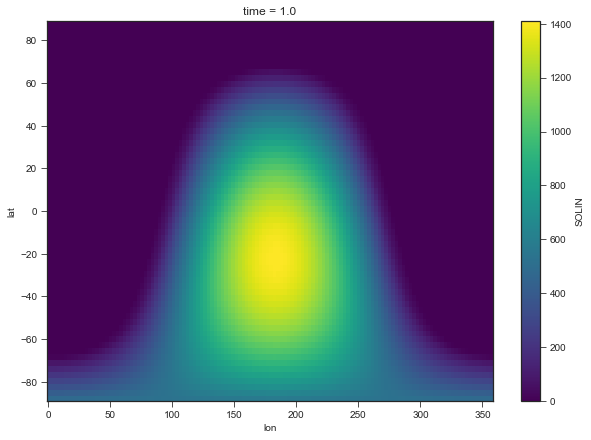

In [77]:
fig, ax = plt.subplots(figsize=(10, 7))
I = ds['SOLIN'].isel(time=0).plot(ax=ax)

In [78]:
def animate(i):
    I = ds['SOLIN'].isel(time=i).plot(ax=ax, add_colorbar=False)
    return (I,)

In [79]:
anim = animation.FuncAnimation(fig, animate,
                               frames=24, interval=150, 
                               blit=True)

In [80]:
HTML(anim.to_html5_video())